<a href="https://colab.research.google.com/github/pragnareddy13/Overlapping-image-stiching/blob/main/ASSIGNMENT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


Importing essential libraries for computer vision and image processing: OpenCV, NumPy, Matplotlib, and OS.

In [ ]:
feature_extraction_alg = 'sift'

feature_to_match = 'bf'

Specifying feature extraction algorithm as SIFT and feature matching algorithm as Brute Force (BF) for image processing.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Computer Vision')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Allowing to access my Google Drive files in Colab environment.

In [ ]:
img1 = cv2.imread('img_1.jpeg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)


img2 = cv2.imread('img_2.jpeg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

Reading two images, converting to RGB and grayscale for further image processing operations.

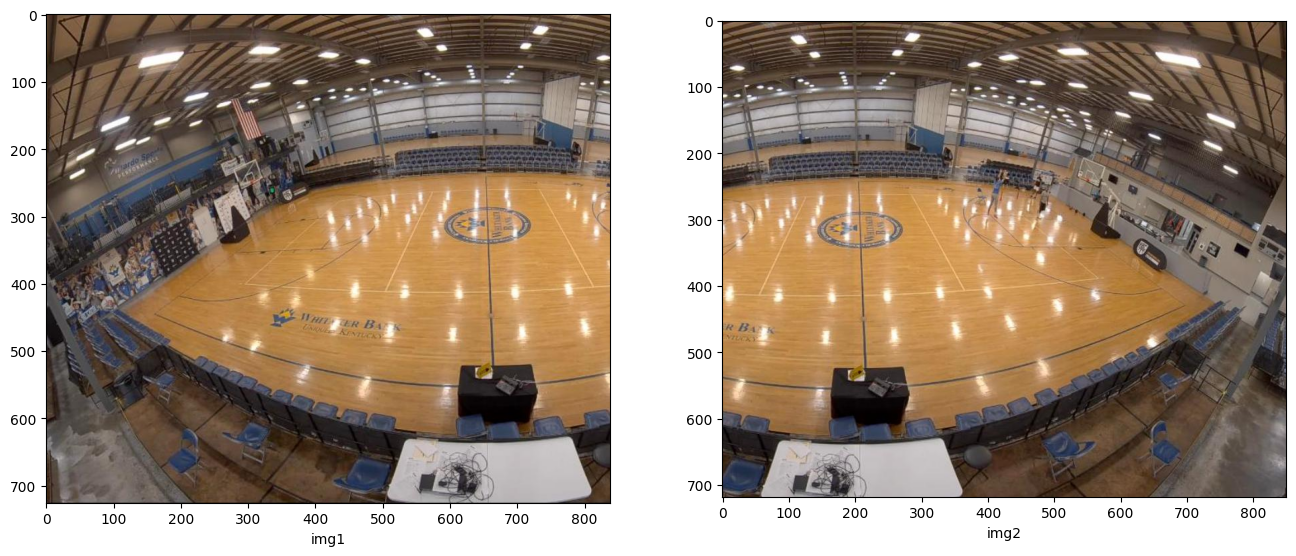

In [ ]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), constrained_layout=False)

# Display img1 on ax1 with a gray colormap
ax1.imshow(img1, cmap='gray')
ax1.set_xlabel('img1')  # removed the tuple and set the font size separately


# Display img2 on ax2 with a gray colormap
ax2.imshow(img2, cmap='gray')
ax2.set_xlabel('img2')  # removed the tuple and set the font size separately


plt.show()  # added to display the plot

Displaying two images side-by-side using subplots with gray colormap and labels.

In [ ]:
def select_descriptor_method(image, method='sift'):

    accepted_methods = ['sift', 'surf', 'orb', 'brisk']
    if method not in accepted_methods: # add an indent to put this in the scope of the function
        raise ValueError(f"Invalid method. Accepted values are: {', '.join(accepted_methods)}")

    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()

    keypoints, features = descriptor.detectAndCompute(image, None)

    return keypoints, features

Defining a function to select and compute image descriptors using various methods.

In [ ]:

keypoints_img1, feature_img1 = select_descriptor_method(img1_gray, method=feature_extraction_alg)
keypoints_img2, feature_img2 = select_descriptor_method(img2_gray, method=feature_extraction_alg)


In [ ]:
for keypoint in keypoints_img2:
    x, y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id

Extracting and processing keypoints from two images using a selected descriptor method.

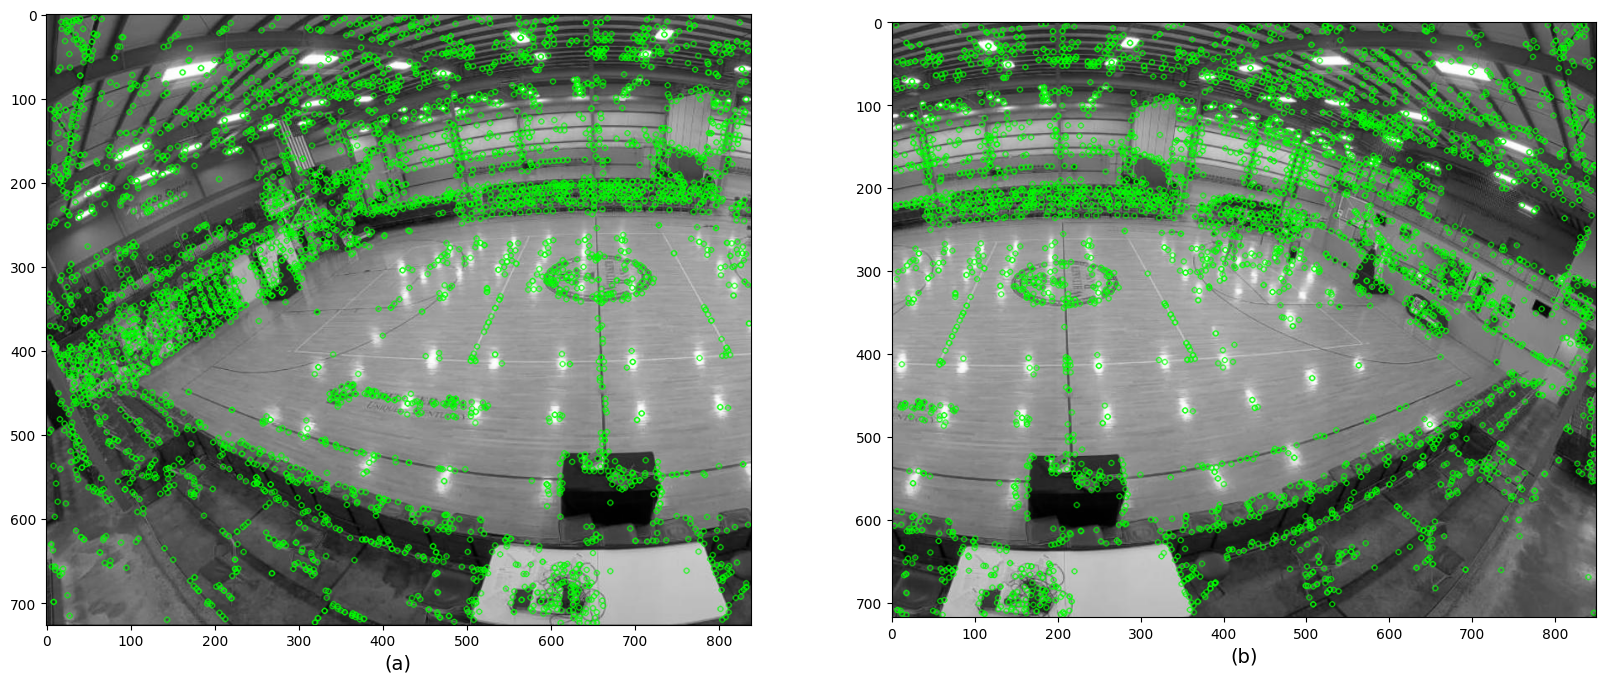

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(img1_gray, keypoints_img1, None, color=(0, 255, 0)))
ax1.set_xlabel('(a)', fontsize=14)

ax2.imshow(cv2.drawKeypoints(img2_gray, keypoints_img2, None, color=(0, 255, 0)))
ax2.set_xlabel('(b)', fontsize=14)


plt.savefig('/content/drive/MyDrive/Computer Vision' + feature_extraction_alg + '_feature_img' + '.jpeg', bbox_inches = 'tight', dpi=300, format='jpeg') # removed optimize=True as it is not a valid argument for jpeg


In [ ]:
def create_matching_object(method, crossCheck):
    if method == 'sift':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    return bf


Visualizing keypoints from two images and creating a Brute-Force matcher object for feature matching based on the method.

In [ ]:


def key_points_matching(feature_img1, feature_img2, method):
    bf = create_matching_object(method, crossCheck=True)

    best_match = bf.match(feature_img1, feature_img2)

    raw_match = sorted(best_match, key = lambda x: x.distance)

    print('Matches in raw with Brute Force', len(raw_match))

    return raw_match


Creating matched characteristics in the drawing for bf
Matches in raw with Brute Force 1748


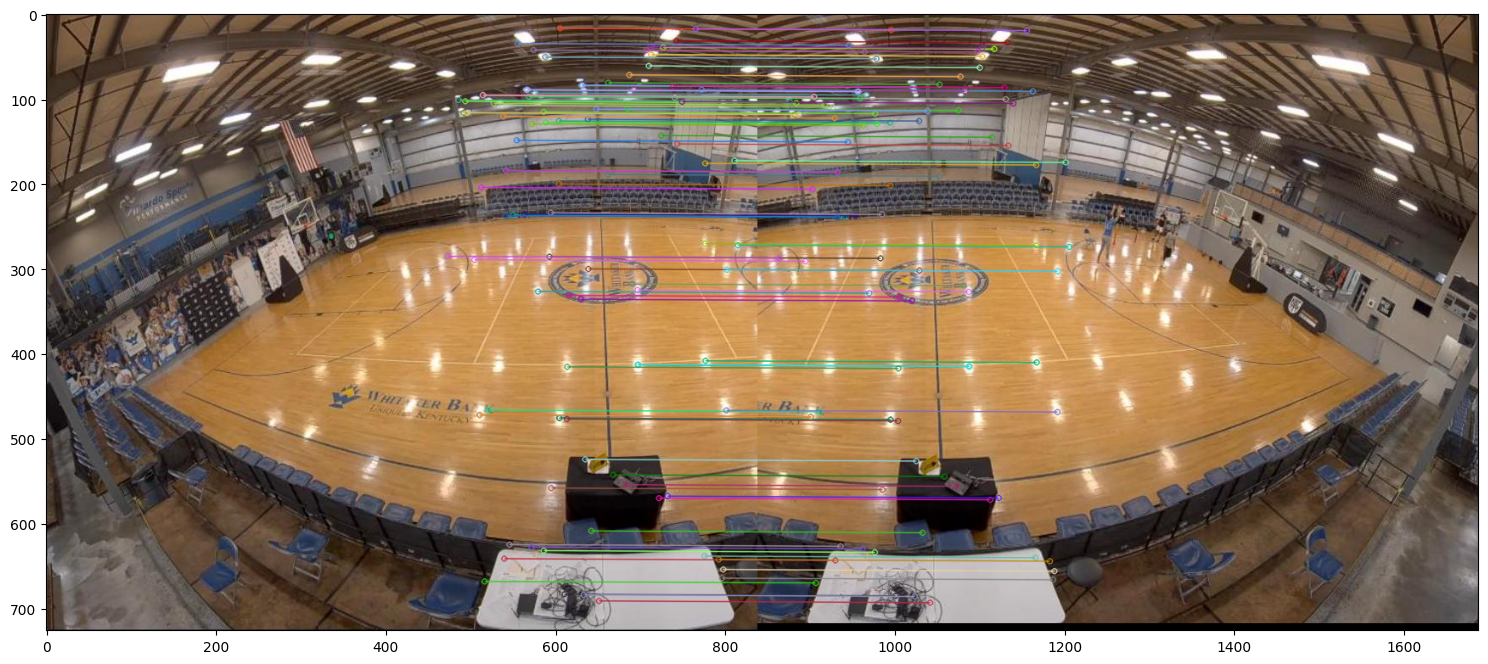

In [ ]:
print('Creating matched characteristics in the drawing for', feature_to_match)
fig = plt.figure(figsize=(20,8))
if feature_to_match == 'bf':
    matches = key_points_matching(feature_img1, feature_img2, method=feature_extraction_alg)
    mapped_feature_img = cv2.drawMatches(img1, keypoints_img1, img2, keypoints_img2, matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(mapped_feature_img)


Performing keypoint matching using Brute-Force matcher and visualizing top 100 matches between two images.

In [ ]:
def homography_stitching(keypoints_img1, keypoints_img2, matches, reprojThresh):
    keypoints_img1 = np.float32([keypoint.pt for keypoint in keypoints_img1])
    keypoints_img2 = np.float32([keypoint.pt for keypoint in keypoints_img2])
    if len(matches) > 4:
        points_img2 = np.float32([keypoints_img1[m.queryIdx] for m in matches])
        points_img1 = np.float32([keypoints_img2[m.trainIdx] for m in matches])
        (H, status) = cv2.findHomography(points_img1, points_img2, cv2.RANSAC, reprojThresh)
        return (matches, H, status)
    else:
        return None


In [ ]:
M = homography_stitching(keypoints_img1, keypoints_img2,matches, reprojThresh=4)
if M is None:
    print('Error')
(matches, Homography_Matrix, status) = M
print(Homography_Matrix)

[[ 9.99851774e-01  3.48786707e-05  4.47983642e+02]
 [ 1.84140785e-05  9.99999210e-01 -2.00950230e+00]
 [-1.80749312e-07 -4.22492361e-08  1.00000000e+00]]


In [ ]:
width = img1.shape[1] + img2.shape[1]
height = max(img1.shape[0], img2.shape[0])

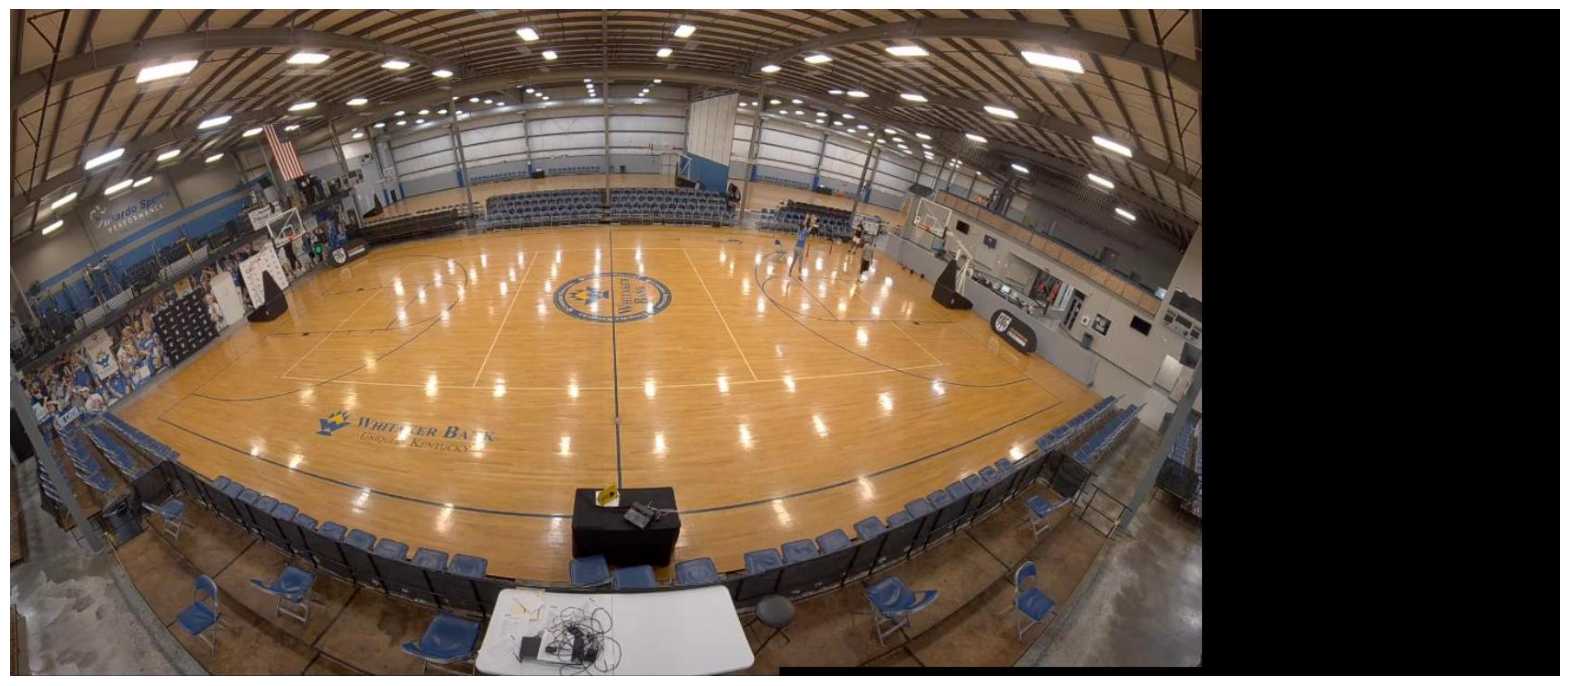

In [ ]:
rslt = cv2.warpPerspective(img2, Homography_Matrix, (width, height))
rslt[0:img1.shape[0], 0:img1.shape[1]] = img1

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(rslt)

Computing homography matrix from matched keypoints between two images using RANSAC algorithm, then stitching images together using the homography matrix, and finally displaying the resulting panorama image.